# Tests using the new data class

In [1]:
import os
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, "/home/usuario/project/src")

%load_ext autoreload
%autoreload

from dataset import Route

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [3]:
dataset_path = os.path.join(datasets_path, all_datasets[0])

In [4]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(dataset_path, "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(dataset_path, "info_eval.csv"))
# Observation means for pc1 and pc2
means1 = np.load(os.path.join(dataset_path, 'observed_mean_pc1.npy'))
means2 = np.load(os.path.join(dataset_path, 'observed_mean_pc2.npy'))

In [5]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [6]:
def routes_to_dict(eval_info, predictions, means1, means2):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        n_points = current['n_points']
        current_pred = predictions.iloc[start_i:start_i+n_points]
        
        all_i = current['first_point']
        route_means1 = means1[all_i:all_i+n_points,:]
        route_means2 = means2[all_i:all_i+n_points,:]
        
        route_obj = Route(current['name'], current_pred)
        
        # Add the observation to the gt table
        route_obj.add_obs_mean(route_means1, route_means2)
        
        routes[current['name']] = route_obj
            
    return routes

In [7]:
routes_dict = routes_to_dict(eval_info, predictions, means1, means2)

In [8]:
from dataset import Route

for key, route in routes_dict.items():
    
    # nn predictions come from neural network! (input data to this script)
    
    # make align3d+kf predictions
    route.run_kalman_filter_align3d(store_name='kf/align3d', generates_route=False)
    route.run_kalman_filter_align3d_means(store_name='kf/align3d+means', generates_route=False)
    route.run_kalman_filter_means(store_name='kf/means', generates_route=True)
    
    # Computes all the routes
    route.compute_routes()
    # Computes all the route errors
    route.compute_all_rmse()

In [9]:
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 20,10

In [10]:
def plot_route(route, names=None, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    fig, ax = plt.subplots()
    
    colours=['orange', 'red', 'green', 'blue', 'pink', 'yellow', 'cyan']
    
    ax.plot(route.routes['gt_x'], route.routes['gt_y'], '-ok', color='black')
    for i, name in enumerate(names):
        ax.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')
        
        
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    ax.legend(prop={'size': 15})

    # Set title to the plot
    ax.set_title(f"route: {route.name}", size=20)
   

In [11]:
def plot_two_route(route, pos_names = None, trans_names=None, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    
    # Link axis (?)
    #fig, ax = plt.subplots(1, 2, figsize=(20,10),sharex='row', sharey='row')
    fig, ax = plt.subplots(1, 2, figsize=(20,10))


    colours_trans = ['orange', 'red', 'blue', 'blue']

    colours_pos = ['black', 'green', 'pink', 'cyan']

    # We build two different axis for relative and absolute
    for axis, motion in zip(ax.flat, ['relative', 'absolute']):
        
        # Always plot ground thruth
        for i, name in enumerate(pos_names):
            axis.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours_pos[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')

        # And plot each route on the axis STEP ROUTES
        for i, name in enumerate(trans_names):
            name_var = f'{name}_{motion}'
            axis.plot(route.routes[f'{name_var}_x'], route.routes[f'{name_var}_y'], '-ok', color=colours_trans[i], label=f'{name} RMSE: {route.trans_error[name_var]:.4f}')

        # Set axis and legend to axis
        axis.legend(prop={'size': 15})
        axis.set_title(f"route: {route.name} {motion}", size=20)
        
    
    # TODO: fix arrows
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    

In [12]:
i = 10

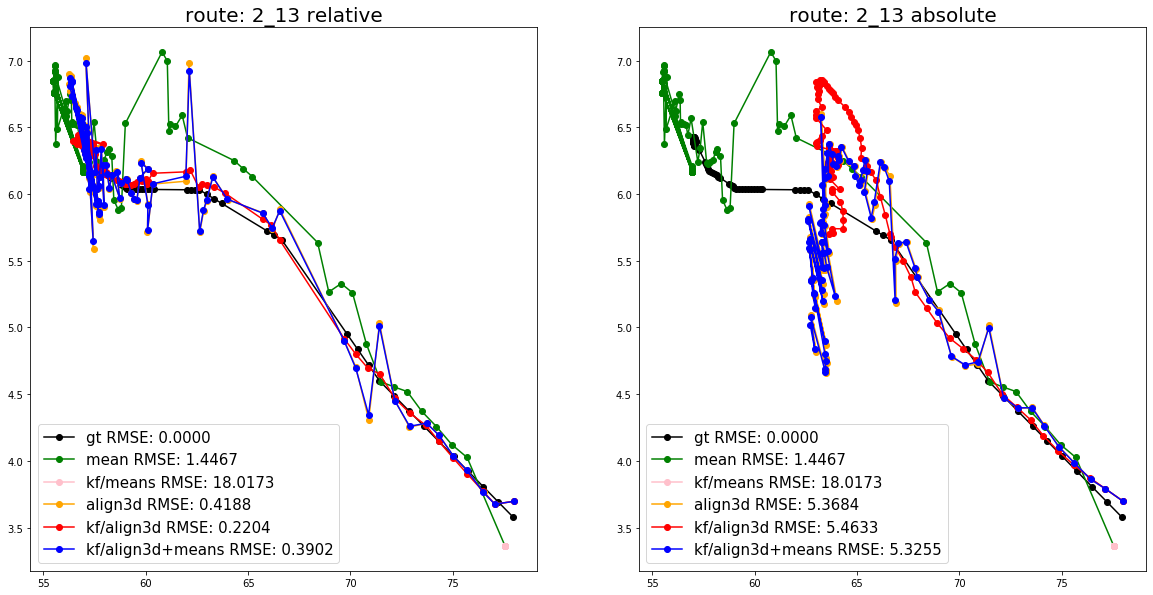

In [14]:
plot_two_route(routes_dict[list(routes_dict.keys())[i]], pos_names = ['gt','mean','kf/means'],trans_names=['align3d', 'kf/align3d', 'kf/align3d+means'])
i += 1

In [19]:
keys = ['obs', 'align3d_absolute', 'align3d+kf_absolute', 'align3d+kf/obs_absolute']
error_dict = {key:0 for key in keys}
for name, route in routes_dict.items():
    for key in keys: 
        error_dict[key] += route.trans_error[key]

for key in keys:
    error_dict[key] = error_dict[key]/len(routes_dict)

KeyError: 'align3d+kf/obs_absolute'

In [ ]:
error_dict

In [51]:
def compute_kf_param(routes_dict, param):
    for key, route in routes_dict.items():
        # nn predictions come from neural network! (input data to this script)
        # make align3d+kf predictions
        route.run_kalman_filter(cat='align3d', store_name='+kf/obs', use_obs=True, param=param)
        route.make_absolute_route('align3d+kf/obs')

        # compute kf/obs error
        route.compute_rmse_error('align3d+kf/obs_absolute')
        
    # Compute error
    error_dict = {key:0 for key in keys}
    for name, route in routes_dict.items():
        error_dict['align3d+kf/obs_absolute'] += route.trans_error['align3d+kf/obs_absolute']
    actual_error = error_dict['align3d+kf/obs_absolute']/len(routes_dict)
    
    
    # Print info
    print(f"With param: {param} error: {actual_error:.4f}")
    
    return actual_error

In [52]:
compute_kf_param(0.2)

With param: 0.2 error: 1.9326


In [57]:
for i in np.arange(0,0.5,0.02):
    compute_kf_param(i)

With param: 0.0 error: 2.0355
With param: 0.02 error: 2.0235
With param: 0.04 error: 2.0119
With param: 0.06 error: 2.0008
With param: 0.08 error: 1.9901
With param: 0.1 error: 1.9797
With param: 0.12 error: 1.9697
With param: 0.14 error: 1.9600
With param: 0.16 error: 1.9505
With param: 0.18 error: 1.9414
With param: 0.2 error: 1.9326
With param: 0.22 error: 1.9240
With param: 0.24 error: 1.9156
With param: 0.26 error: 1.9075
With param: 0.28 error: 1.8995
With param: 0.3 error: 1.8918
With param: 0.32 error: 1.8843
With param: 0.34 error: 1.8770
With param: 0.36 error: 1.8698
With param: 0.38 error: 1.8628
With param: 0.4 error: 1.8560
With param: 0.42 error: 1.8493
With param: 0.44 error: 1.8428
With param: 0.46 error: 1.8364
With param: 0.48 error: 1.8301
